# Generative linear models para ver tendencias de COVID-19 en Chile

In [1]:
#Cargamos datos
import pandas as pd

colmap = {
    'Evolución acumulada de casos': 'total_cases',
    'Evolución de nuevos casos': 'new_cases'
}
df = pd.read_csv('covid19_cl_Resumen Allkun Analítica_Gráfico combinado.csv').rename(columns=colmap)

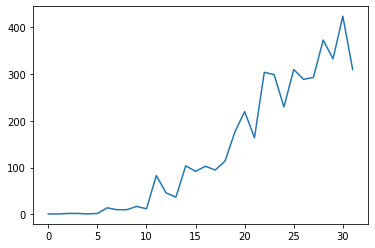

In [2]:
# Los miramos en el grafico
df.new_cases.plot()

In [3]:
import numpy as np

# Preparamos X, y
X = np.expand_dims(df.index.to_numpy(), 1)
y = df.new_cases

In [4]:
# FUERA DE USO
# Alternativa para hacer grid search de splines

#gam = LinearGAM(n_splines=25,spline_order=3)
#gam.gridsearch(X, y, n_splines=np.arange(50))

In [5]:
# FUERA DE USO
# Alternativa para hacer grid search de lambadas

#gam = LinearGAM(n_splines=4,spline_order=3).gridsearch(X, y, lam=np.logspace(-12, 12, 5000))

In [6]:
from pygam import LinearGAM, s, f

# Definimos nuetras GAM como una linear de s(0, n_splines=n_splines)
n_splines = 20
gam = LinearGAM(s(0, n_splines=n_splines))

In [7]:
# Hacemos fit
gam.fit(X, y)

LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, terms=s(0) + intercept, tol=0.0001, 
   verbose=False)

In [8]:
# Un sumario

gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      8.3143
Link Function:                     IdentityLink Log Likelihood:                                  -252.8146
Number of Samples:                           32 AIC:                                              524.2579
                                                AICc:                                             533.1182
                                                GCV:                                             1967.7399
                                                Scale:                                           1076.1823
                                                Pseudo R-Squared:                                   0.9553
Feature Function                  Lam

<ipython-input-8-4bebcc94ea8e>:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


### Ploteamos las predicciones para para el modelo y sus intervalos

In [9]:
# Pongamos fechas bonitas
import datetime

def nday2datetime(nday):
    base_date = datetime.datetime(2020, 3, 2)
    return base_date + datetime.timedelta(days=nday)

def nday2datetime_list(nday_list):
    result = []
    for nday in nday_list:
        result.append(nday2datetime(nday))
        
    return result


df['ds'] = pd.Series(df.index).apply(nday2datetime)

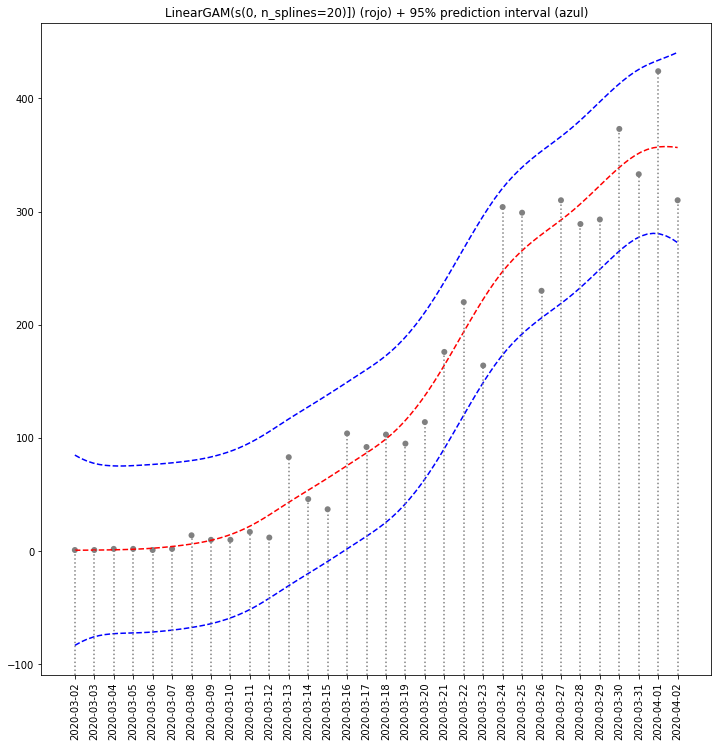

In [10]:
import matplotlib.pyplot as plt

def plot_gam(gam, title, X, y, save = False):
    fig, ax = plt.subplots(figsize=(12, 12))
    #plt.figure(figsize=(12, 12));

    XX = gam.generate_X_grid(0)

    plt.plot(nday2datetime_list(XX[:, 0]), gam.predict(XX), 'r--')
    plt.plot(nday2datetime_list(XX[:, 0]), gam.prediction_intervals(XX), color='b', ls='--')

    plt.scatter(X, y, facecolor='gray', edgecolors='none')
    plt.title(title)
    plt.xticks(X, rotation=90)
    
    # Create transformers for lines
    data2figure_trans = ax.transData
    figure2ax_trans = ax. transAxes.inverted()
    
    for point in zip(X, y.values):
        # Convert point from data to figure cordinate system
        f_point = data2figure_trans.transform([0, point[1]])
        # Convert point from figure to axis coordinate system
        a_point = figure2ax_trans.transform(f_point)
        
        plt.axvline(point[0], ymax=a_point[1], linestyle=':', color='gray')
    if save:
        plt.savefig(f'plots/{title}.png')
    plt.show()
    plt.close()
        
plot_gam(gam, f'LinearGAM(s(0, n_splines={n_splines})]) (rojo) + 95% prediction interval (azul)', df.ds, y)

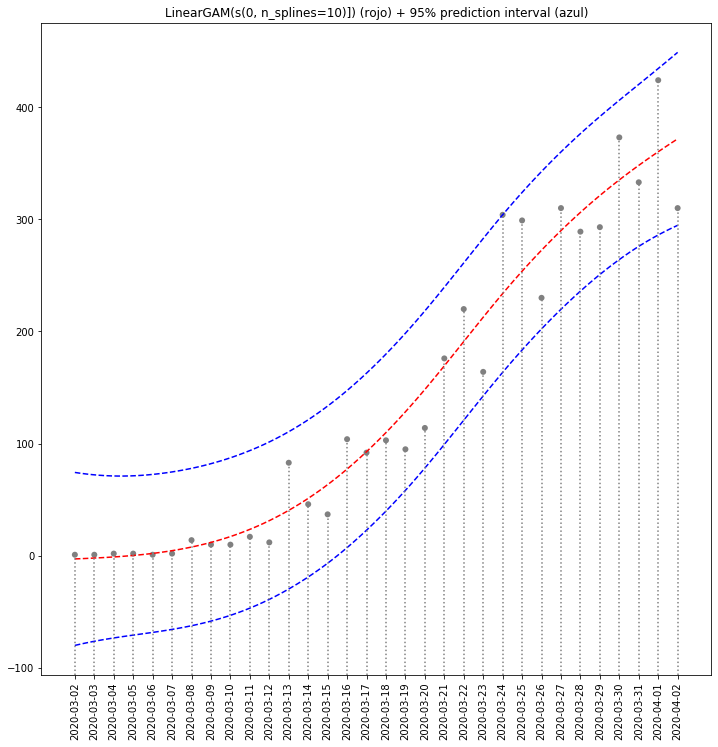

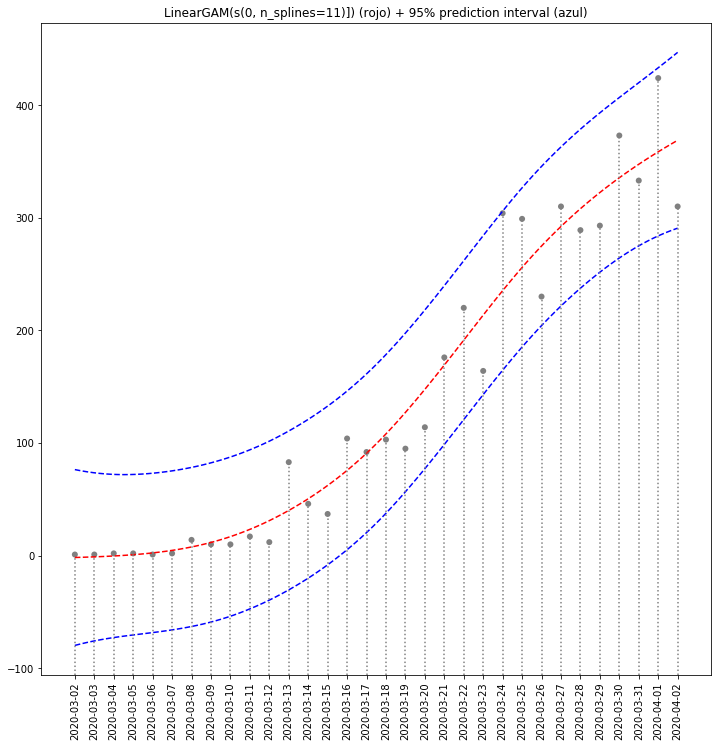

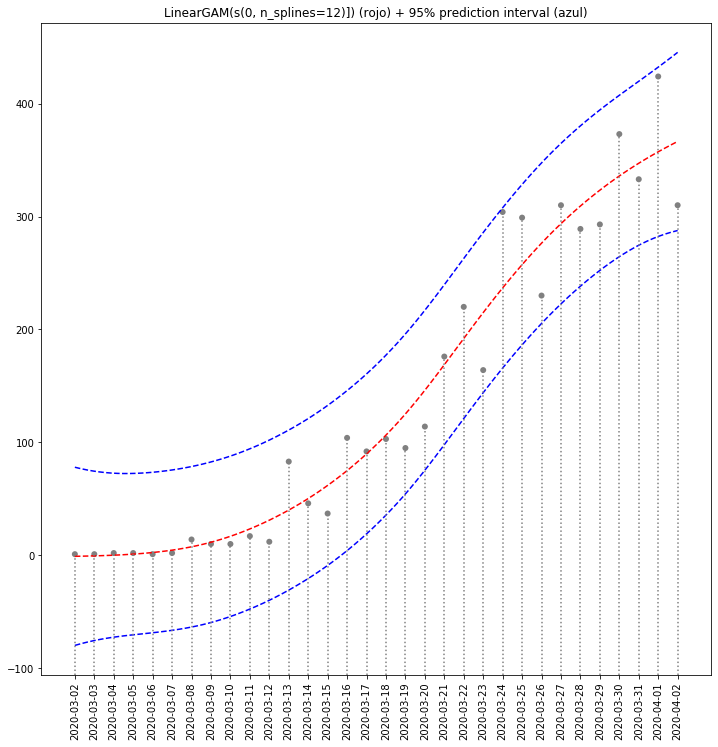

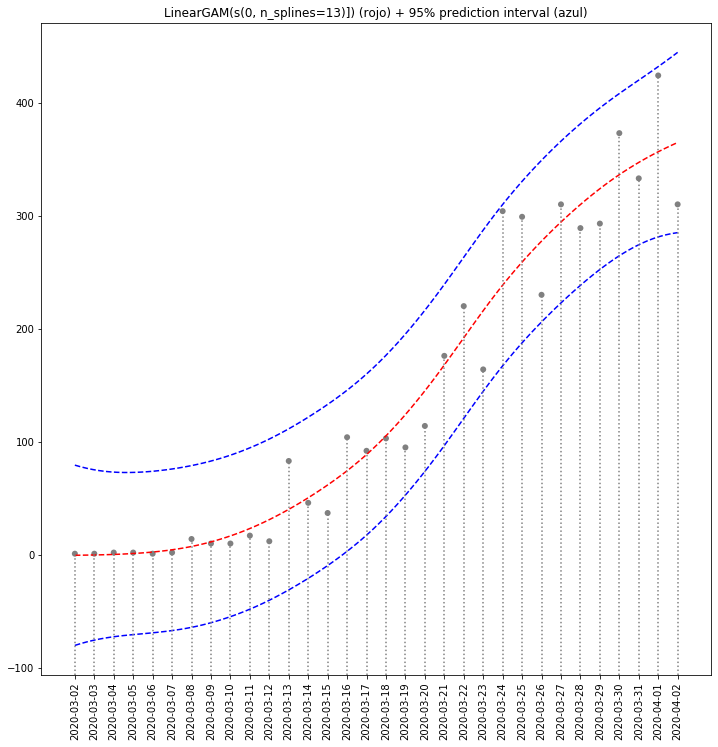

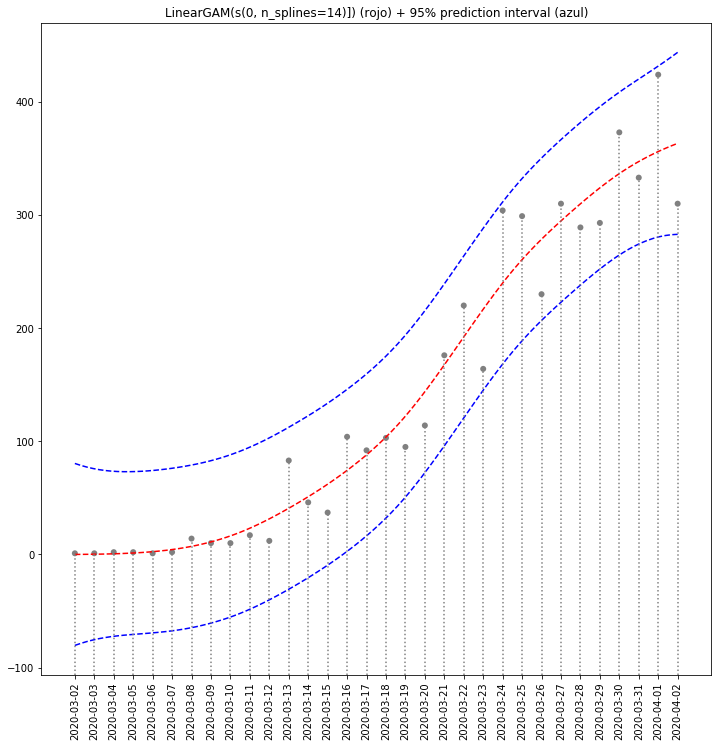

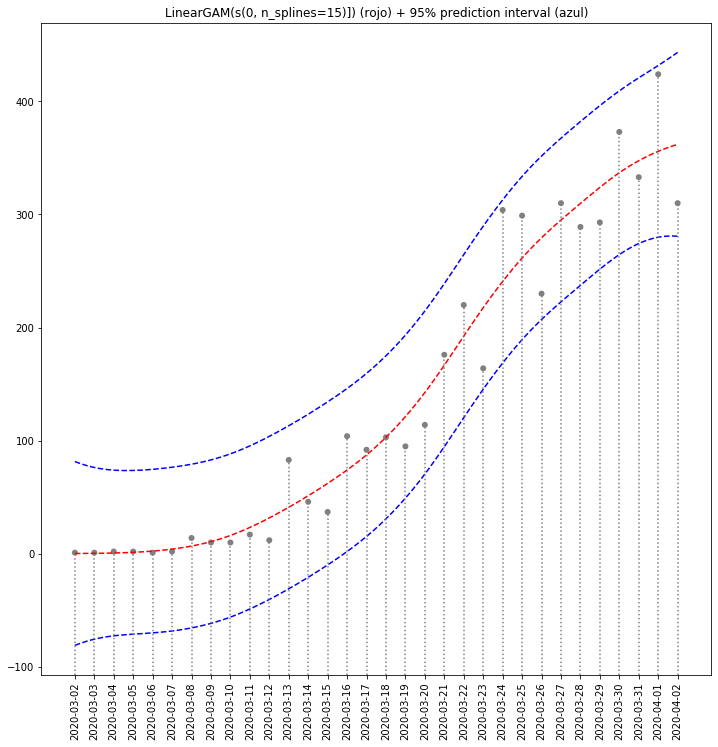

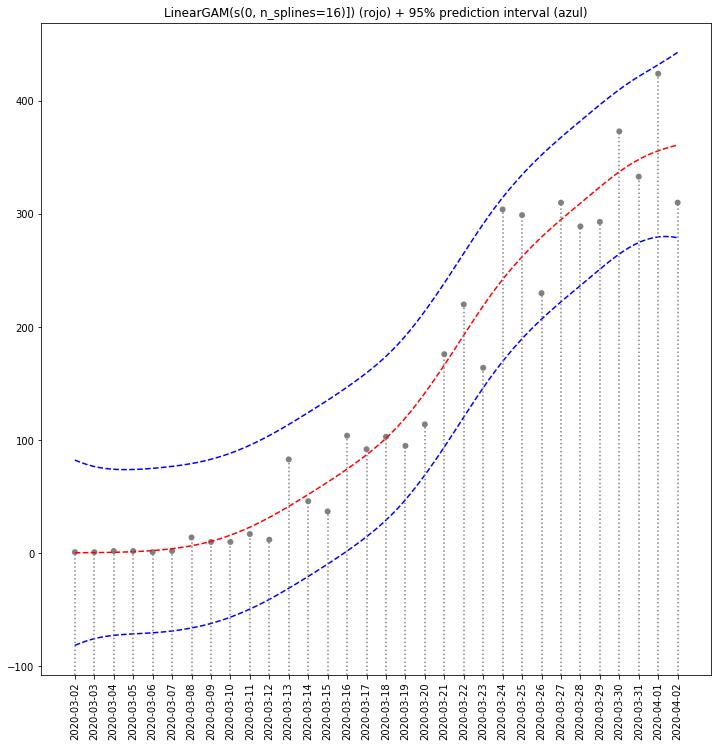

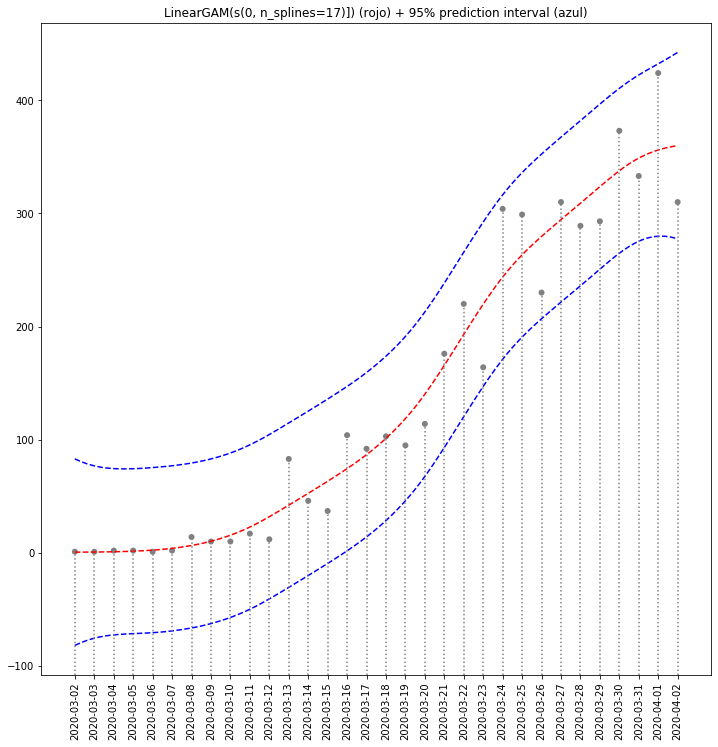

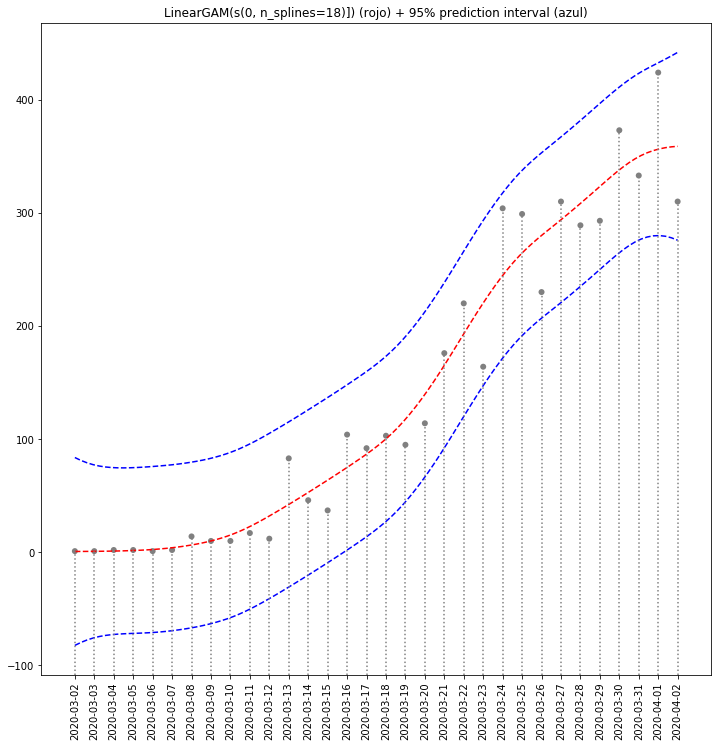

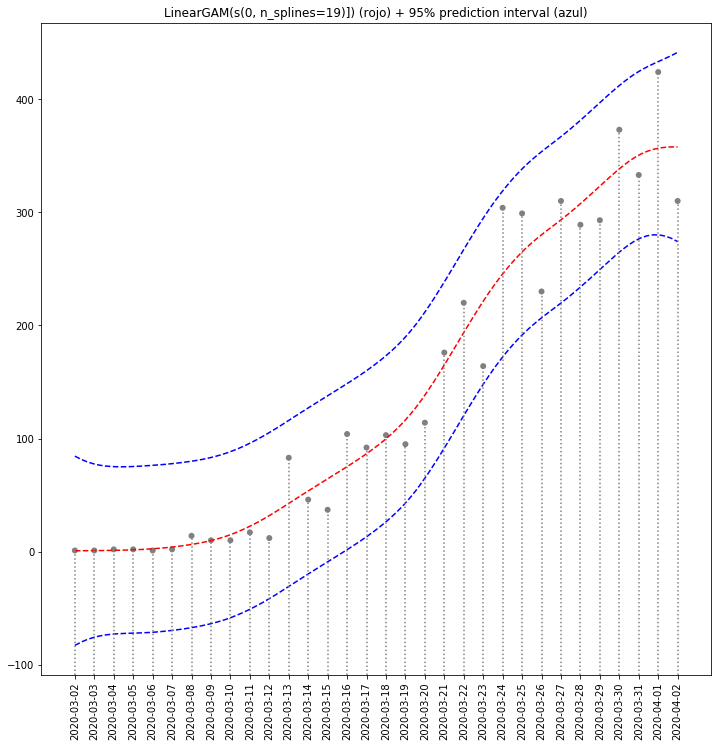

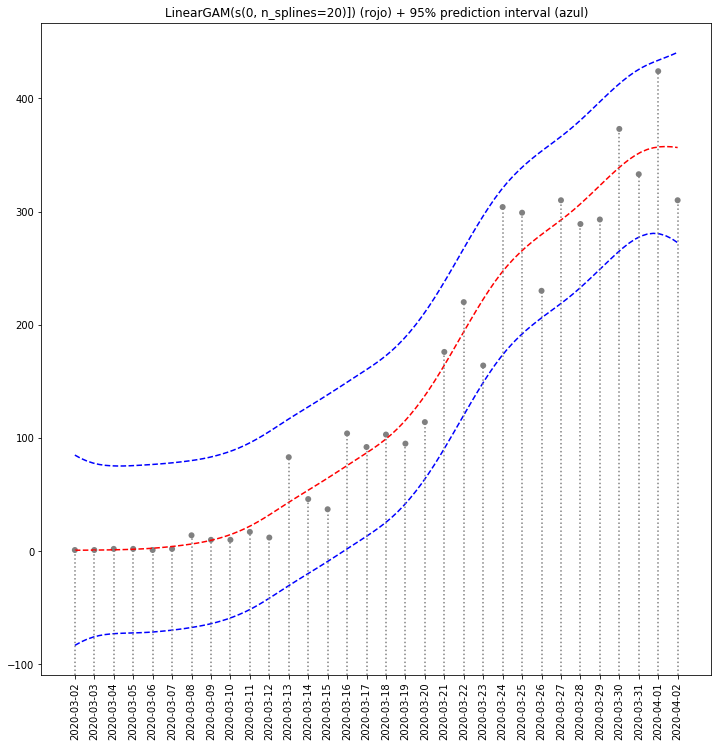

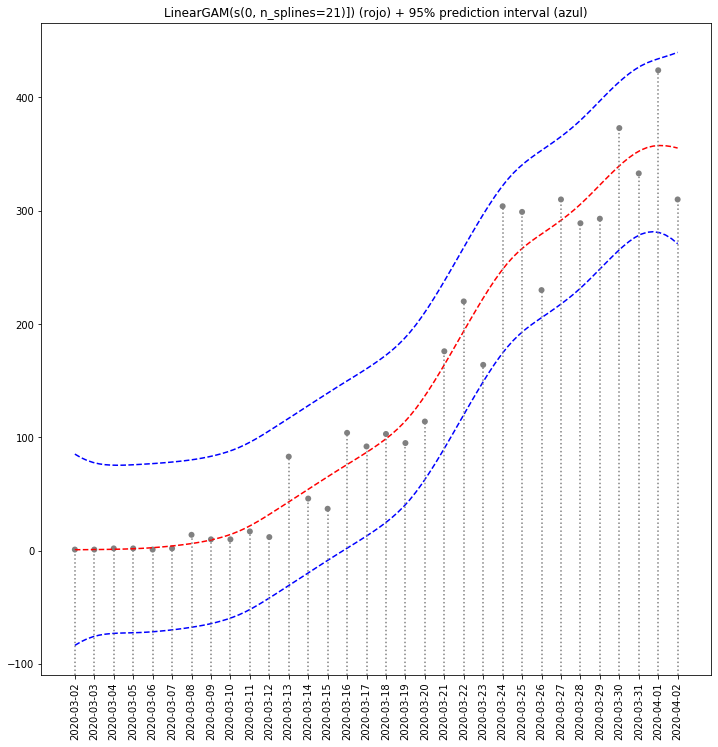

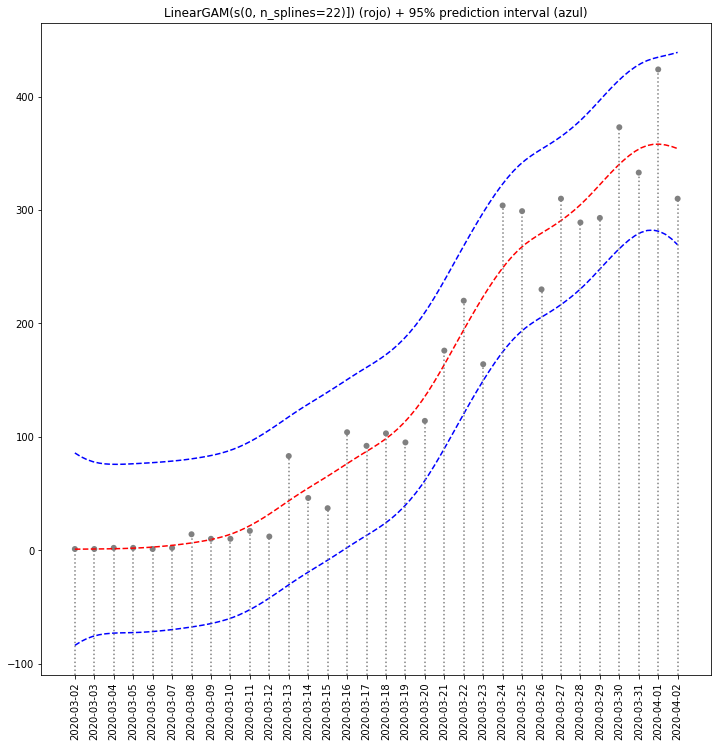

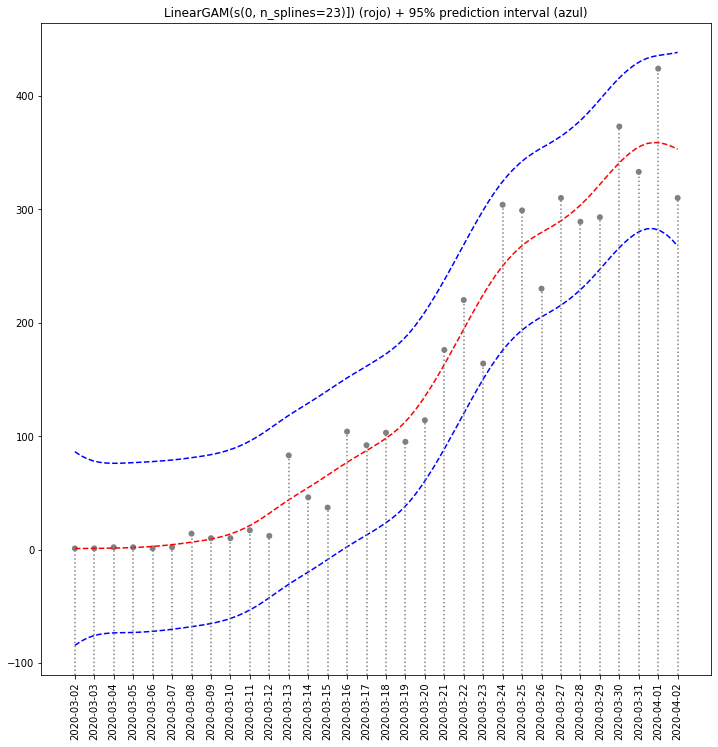

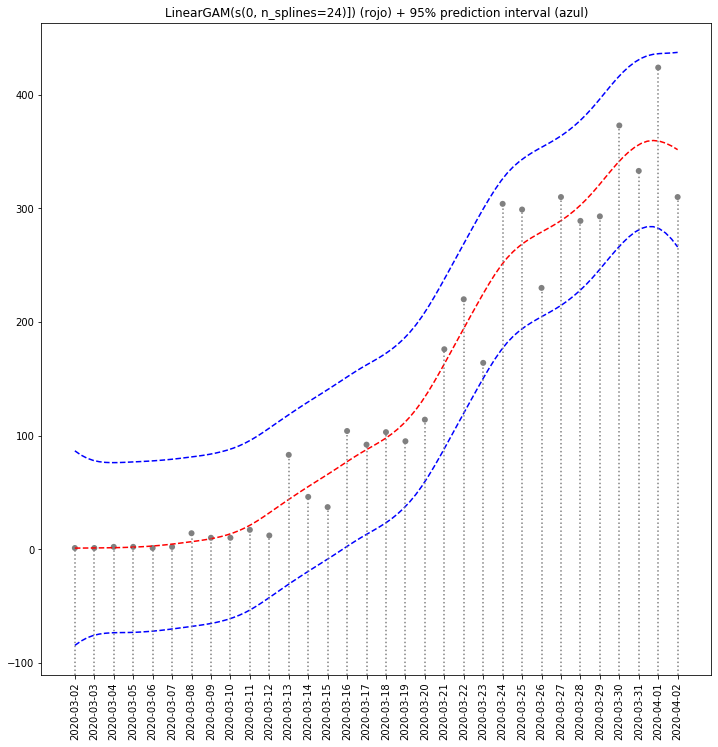

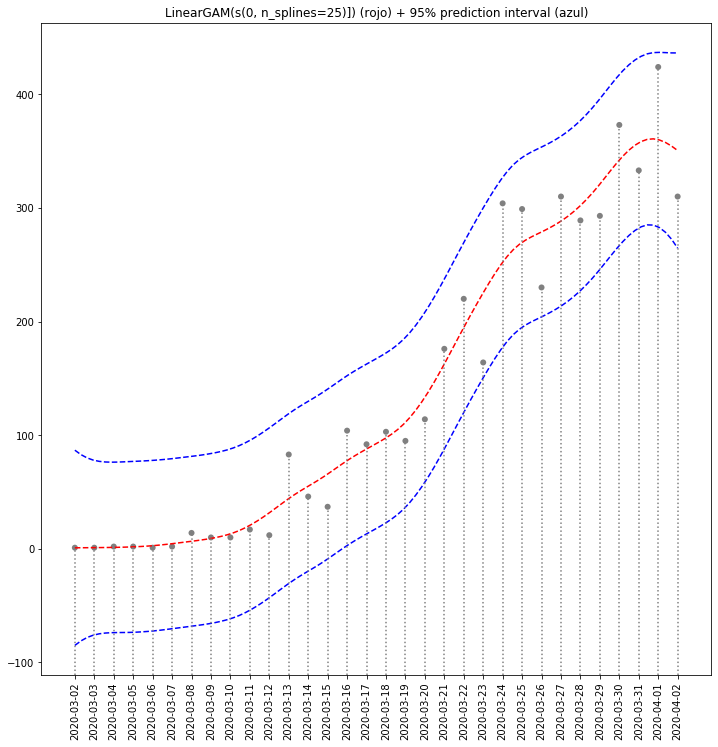

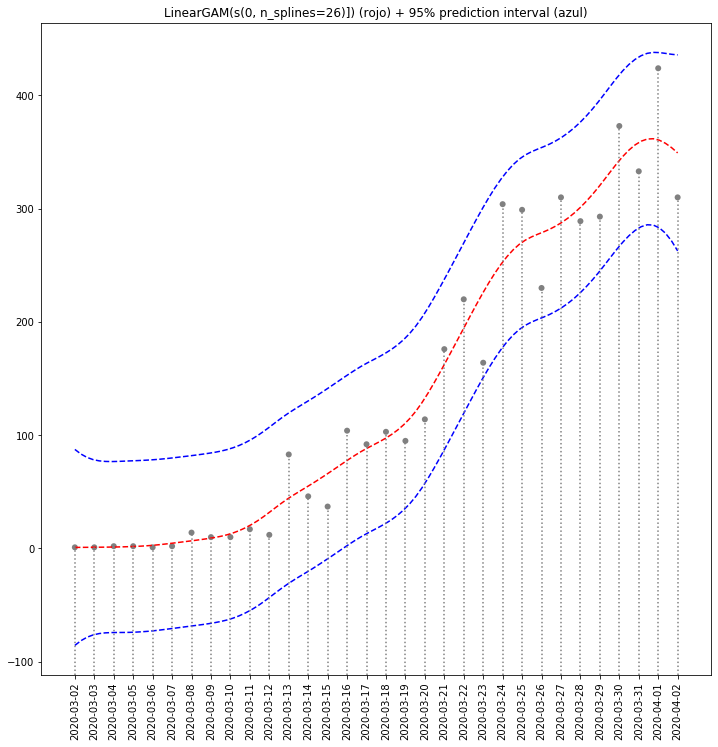

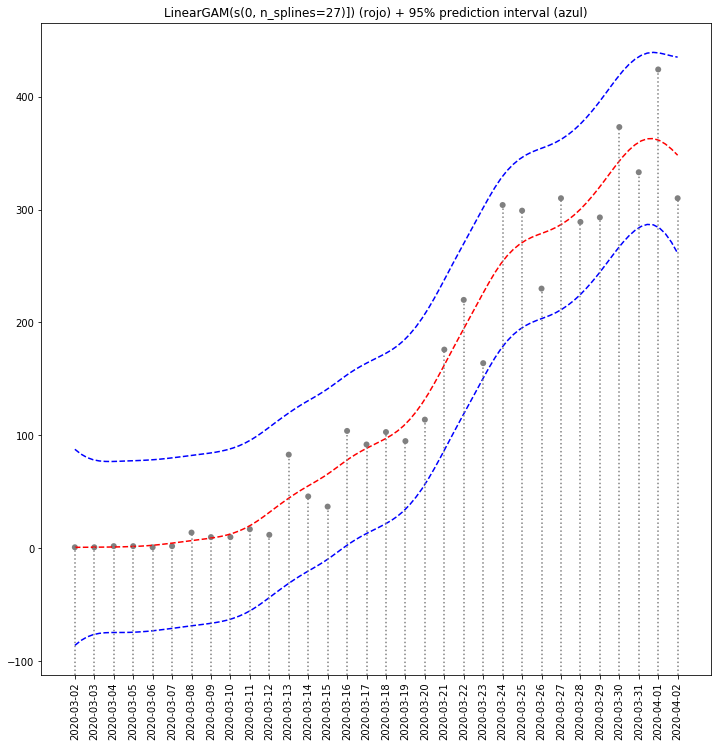

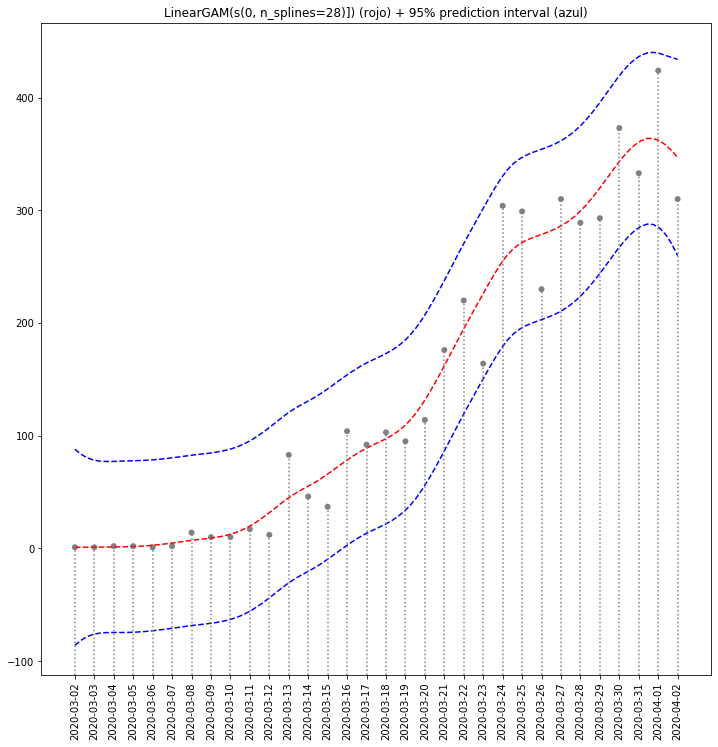

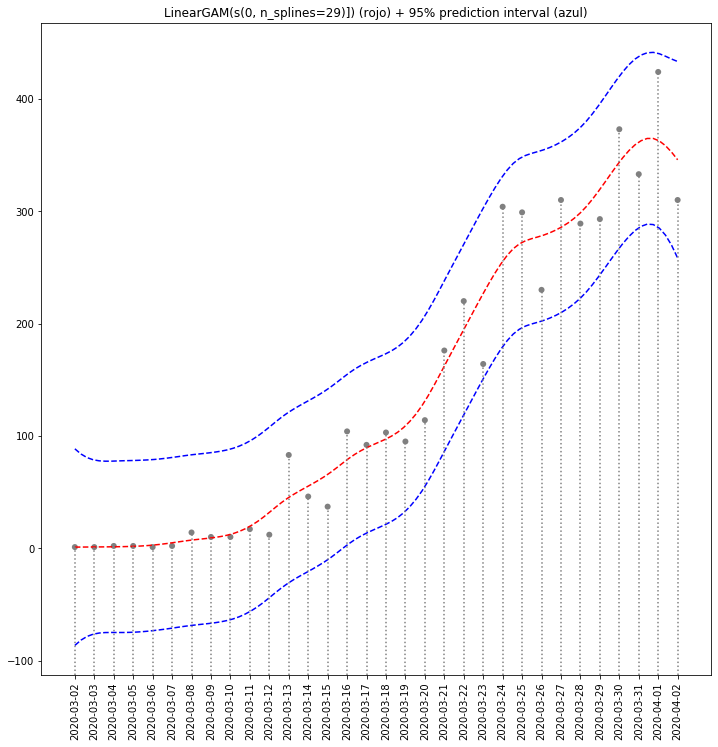

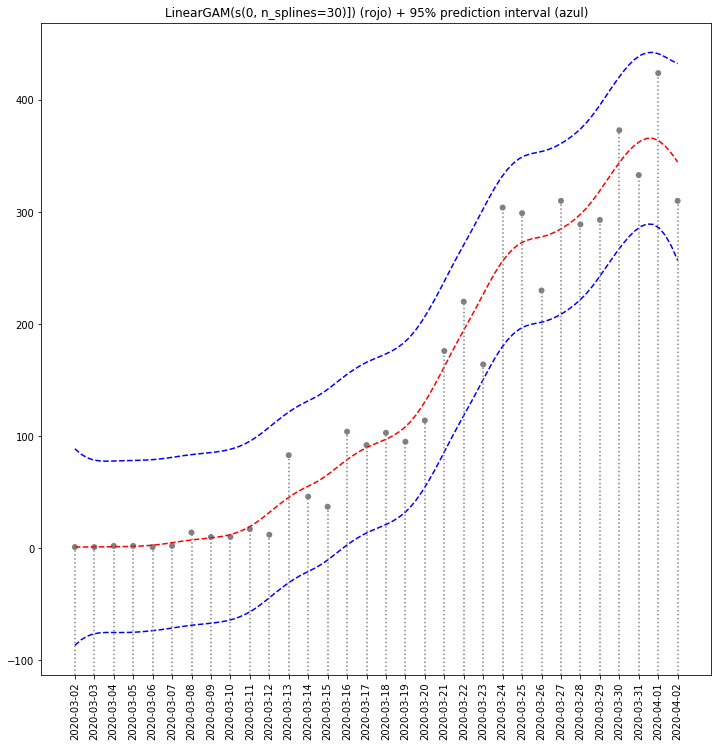

In [11]:
# Miremos un rango
# Veremos modelos muy generales donde no se pueden ver sub-tendencias clararas por un lado
# y modelos overfited por el otro donde cada variación se sobre interpreta mucho.
# La idea es entender como se comporta el modelo en un rango de hiper-parametros

for n_splines in range(10, 31):
    gam = LinearGAM(s(0, n_splines=n_splines))
    gam.fit(X, y)
    plot_gam(gam, f'LinearGAM(s(0, n_splines={n_splines})]) (rojo) + 95% prediction interval (azul)', df.ds, y, True)

In [12]:
# Miremos los coeficientes
gam.coef_

array([-135.77034196, -135.62016213, -135.46368731, -135.31019109,
       -134.88523454, -132.98690107, -129.56548617, -127.71161939,
       -125.33842808, -116.81432675,  -99.63623488,  -84.80005746,
        -76.94620882,  -59.89709723,  -46.35298846,  -39.69104873,
        -27.54255613,    3.30071671,   43.63118669,   78.16631644,
        118.19632965,  139.48725938,  140.20893785,  150.04073252,
        166.58630099,  197.01577119,  224.75400038,  234.26101362,
        209.71578071,  175.56444547,  136.59622252])